In [15]:
import os
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms.v2 as T
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import transformers

class IMDBDataset(torch.utils.data.Dataset):
    def __init__(self, root="/home/wipkat/data/imdb", split="train"):
        path = os.path.join(root, "data.csv")
        self.data = []
        with open(path) as stream:
            lines = stream.readlines()[1:]
            for line in lines:
                parts = [v.strip() for v in line.rsplit(",",1)]
                replace = { "\\": "", "\"": "", "<br />": "\n" }
                for k,v in replace.items():
                    parts[0] = parts[0].replace(k,v)
                parts[1] = torch.tensor(parts[1]=="positive")
                self.data.append(parts)
        self.split = split
        s = int(len(self.data) * 0.95)
        if split == "train":
            self.data = self.data[:s]
        else:
            self.data = self.data[s:]
            
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx%len(self)]
        
class SentimentDataset(torch.utils.data.IterableDataset):
    def __init__(self, dataset, size=(32,32)):
        self.dataset = dataset
        self.size = size
        self.tokenizer = transformers.GPT2Tokenizer.from_pretrained("gpt2")

    def vocabulary_size(self):
        return self.tokenizer.vocab_size
        
    def __iter__(self):
        return self
        
    def __next__(self):
        text, label = self.dataset[torch.randint(len(self.dataset), ()).item()]
        tokens = self.tokenizer.encode(text)
        tokens = torch.tensor(tokens, dtype=torch.long)
        tokens = tokens[:np.prod(self.size)]
        cx = max(int(math.ceil(tokens.shape[-1]**0.5)), self.size[1]//2)
        cy = int(math.ceil(len(tokens) // cx))
        tokens = F.pad(tokens, (0,cx*cy-len(tokens)))
        tokens = tokens.unflatten(-1,(cy,cx))
        px, py = self.size[1]-cx, self.size[0]-cy
        tokens = F.pad(tokens, (px//2, px-px//2, py//2, py-py//2))
        target = torch.full_like(tokens, 1 if label else -1)
        return tokens[None], target[None]
        

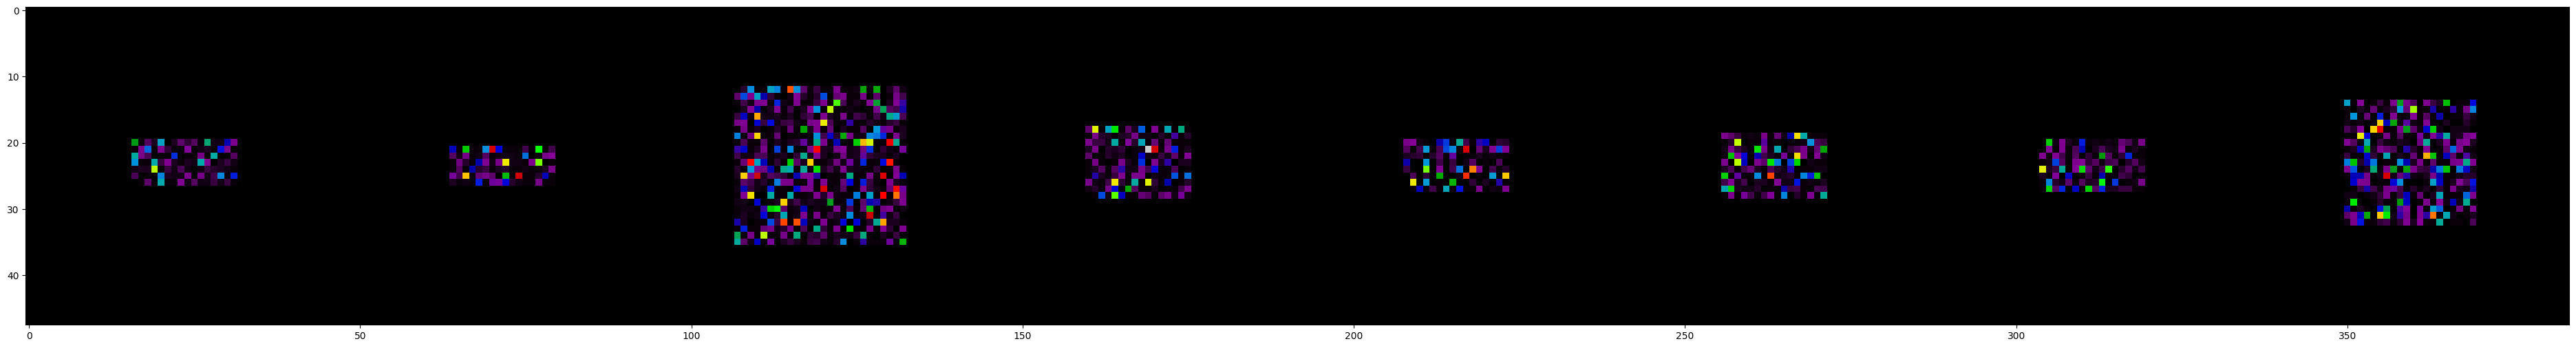

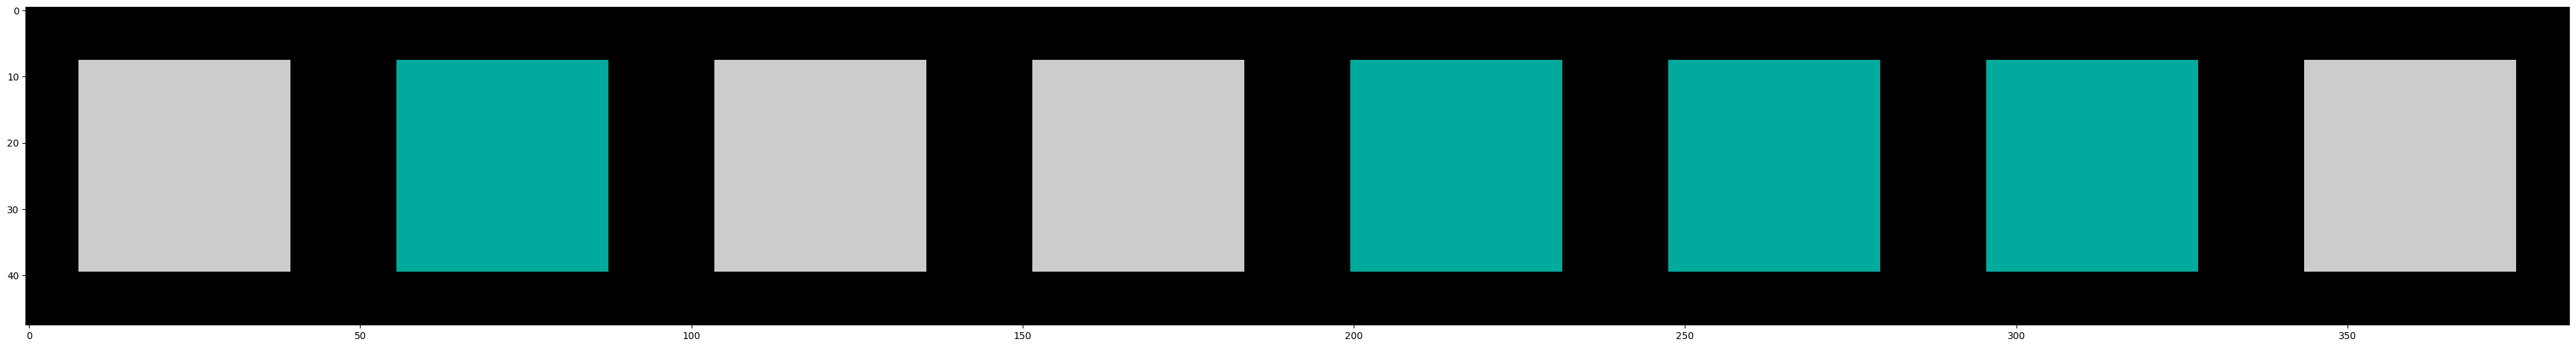

In [16]:
dataset = SentimentDataset(dataset=IMDBDataset())
loader = torch.utils.data.DataLoader(dataset, batch_size=8)
batch, target = next(iter(loader))
batch = batch / dataset.vocabulary_size()
target = target.sigmoid()
batch = torch.cat([F.pad(b, (8,8,8,8)) for b in batch.unbind()], -1)
plt.figure(figsize=(48,6))
plt.imshow(batch.permute(1,2,0).numpy(), cmap="nipy_spectral")
plt.show()

target = torch.cat([F.pad(t, (8,8,8,8)) for t in target.unbind()], -1)
target = target
plt.figure(figsize=(48,6))
plt.imshow(target.permute(1,2,0).numpy(), cmap="nipy_spectral")
plt.show()
